### Exercise 6 - Model Predictive Control

In this exercise, we consider a Model Predicitve Control (MPC)  approach to control the inverted pendulum on cart. 
The system dynamics are given via the ODE:
\begin{equation}\label{eq:dynamics}
\begin{aligned}
\dot{p} =& v \\
\dot{\theta} =& \omega \\
\dot{v} =  & 
-\frac{m l \sin(\theta)\omega^2 + m g \cos(\theta)\sin(\theta)+F}{ M + m - m\cos(\theta)\cos(\theta)}\\
\dot{\omega} =& -\frac{m l \cos(\theta)\sin(\theta) \omega^2 + F \cos(\theta)+(M+m)g \sin(\theta)}{l(M + m - m\cos(\theta)\cos(\theta))},
\end{aligned}
\end{equation} 
where $\theta$ is the angle describing the orientation of the pendulum, $\omega$ is its angular velocity and $p$ and $v$ are position and velocity of the cart.
Here,  $ M, m, g$ and $ l $ are parameters of the model describing the mass of the cart, the mass of the ball, the gravity constant and the length of the rod respectively.  
The force $ F $ is the control action, i.e. $a := F$.

The goal is to design a feedback policy capable of swinging up the pendulum starting from $\theta = \pi$. 


Consider the following optimal control problem, 
<img src="imgs/ocp.png" alt="nlp" width="350"/>


where $F(s,a)$ describes the discretized dynamics obtained by applying three step of the explicit RK4 integrator with integration interval $h=0.05$.





In [1]:
import numpy as np
from casadi import *
from model import Model
from utils import integrate_RK4
from get_LQR_gain import get_LQR_gain

# continuous dynamics
ns = 4
na = 1

# constants
M = 1. # mass of the cart [kg]
m = 0.1 # mass of the ball [kg]
g = 9.81 # length of the rod [m]
l = 0.8 # gravity constant [m/s^2]

# set up states & controls
x1      = SX.sym('x1')
theta   = SX.sym('theta')
v1      = SX.sym('v1')
dtheta  = SX.sym('dtheta')  

s_expr = vertcat(x1, theta, v1, dtheta)

# controls
F = SX.sym('F')
a_expr = vertcat(F)

# dynamics
cos_theta = cos(theta)
sin_theta = sin(theta)

denominator = M + m - m*cos_theta*cos_theta
s_dot = vertcat(v1,
                dtheta,
                (-m*l*sin_theta*dtheta*dtheta + m*g*cos_theta*sin_theta+F)/denominator,
                (-m*l*cos_theta*sin_theta*dtheta*dtheta + F*cos_theta+(M+m)*g*sin_theta)/(l*denominator)
                )

# discrete dynamics
dt = 0.05
n_steps = 5
F_discrete = integrate_RK4(s_expr, a_expr, s_dot, dt, n_steps)

# steady state
s_steady_state = np.zeros((ns, 1))
a_steady_state = np.zeros((na, 1))

model = Model(s_expr, a_expr, F_discrete, s_steady_state, a_steady_state)

a_max = 35
a_min = -a_max

Q = np.diag([1e3, 1e4, 1e-2, 1e-2])
R = np.diag([1])

A = model.J_x(model.s_steady_state, model.a_steady_state).full()
B = model.J_u(model.s_steady_state, model.a_steady_state).full()

(K, P) = get_LQR_gain(A, B, Q, R)

stage_cost_expr = s_expr.T @ Q @ s_expr + a_expr.T @ R @ a_expr
terminal_cost_expr = s_expr.T @ P @ s_expr

stage_cost = Function('stage_cost', [s_expr, a_expr], [stage_cost_expr])
terminal_cost = Function('terminal_cost', [s_expr], [terminal_cost_expr])

### 6.1 OCP formulation

Complete the following template to obtain a solver for the above OCP, which is parametric in the initial state $ \bar s_0$.

In [2]:
class  OCPsolver:

    def __init__(self, model, stage_cost, terminal_cost, N, a_max, a_min):

        self.N = N
        self.model = model

        ns = model.ns
        na = model.na

        # setup OCP

        # optimization variables
        s_traj = SX.sym('s_traj', ns*(N+1), 1)
        a_traj = SX.sym('a_traj', na*N, 1)

        # split trajectories to obtain x and u for each stage
        s_ns = vertsplit(s_traj, np.arange(0, ns*(N+1)+1, ns))
        a_ns = vertsplit(a_traj, np.arange(0, na*N+1, na))

        # initial state (will be a parameter of the optimization problem)
        s0_bar = SX.sym('s0_bar', ns, 1)

        cost = 0

        # initial constraint
        constraints = [s_ns[0] - s0_bar]

        for n in range(N):
            s0 = s_ns[n]
            a0 = a_ns[n]
            s1 = s_ns[n+1]
            
            f0 = model.f(s0, a0)

            # add stage cost to objective
            cost += stage_cost(s0, a0)

            # add continuity contraint
            constraints += [s1-f0] 
        
        # add terminal cost
        cost += terminal_cost(s1)

        # continuity constraints and bounds on u
        constraints = vertcat(*constraints, a_traj)

        # set upper and lower bounds 
        # zeros for continuity constraints, a_max/a_min fro control bounds
        self.ubg = vertcat(np.zeros((ns*(N+1))), a_max*np.ones((N*na)))
        self.lbg = vertcat(np.zeros((ns*(N+1))), a_min*np.ones((N*na)))

        self.ocp = {'f': cost, 'x': vertcat(s_traj, a_traj), 'g': constraints, 'p':s0_bar}
        self.solver = nlpsol('solver', 'ipopt', self.ocp)

        # initialize current solution guess
        self.s_current = np.zeros((ns*(N+1), 1))
        self.a_current = np.zeros((na*N, 1))


    def solve(self, s0, s_traj_init=None, a_traj_init=None):

        if s_traj_init is not None:
            self.s_current = s_traj_init

        if a_traj_init is not None:
            self.a_current = a_traj_init

        # solve the NLP
        sol = self.solver(x0=vertcat(self.s_current, self.a_current), lbg=self.lbg, ubg=self.ubg, p=s0)
        
        w_opt = sol['x'].full()

        s_opt = w_opt[:(self.N+1)*self.model.ns]
        a_opt = w_opt[(self.N+1)*self.model.ns:]

        cost = sol['f'].full()

        self.s_current = s_opt
        self.a_current = a_opt

        a0_opt = a_opt[:self.model.na]
        return a0_opt


    def reset(self):
        self.s_current = np.zeros((self.model.ns*(self.N+1), 1))
        self.a_current = np.zeros((self.model.na*self.N, 1))


### 6.2 Closed Loop Simulation

Complete the following template to obtain a closed loop simulation of the system. 

Do you expect the closed loop trajectories obtained with the MPC approach to differ from the trajectories you'd obtain by solving a single open loop OCP? Why?



In [3]:
from plot_utils import plot_trajectories_pendulum_on_cart
import matplotlib.pyplot as plt

N_steps = 100
N_horizon = 20

ocp_solver = OCPsolver(model, stage_cost, terminal_cost, N_horizon, a_max, -a_max)

s_traj = np.zeros((ns, N_steps+1))
a_traj = np.zeros((na, N_steps))

s0 = np.array([0, np.pi, 0, 0])

# closed-loop simulation
s_traj[:, 0] = s0

for n in range(N_steps):
    s = s_traj[:, n]
    a = ocp_solver.solve(s)

    a_traj[:, n] = a
    s_traj[:, [n+1]] = model.simulate(s, a)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      384
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      170

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

  86  3.2925653e+05 2.17e+00 8.79e+04  -1.0 1.82e+03    -  4.85e-02 3.25e-03h  4
  87  3.6218237e+05 2.15e+00 1.12e+05  -1.0 1.83e+03    -  1.00e+00 5.66e-03h  3
  88  4.8525980e+05 2.12e+00 1.10e+05  -1.0 1.81e+03    -  2.09e-02 1.72e-02h  1
  89  4.9048923e+05 2.11e+00 1.50e+05  -1.0 4.33e+02    -  1.25e-01 7.19e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  5.2395080e+05 2.11e+00 1.50e+05  -1.0 2.27e+03    -  2.89e-03 3.46e-03h  4
  91  5.5114542e+05 2.10e+00 1.49e+05  -1.0 2.67e+03    -  5.34e-03 2.57e-03h  4
  92  6.0204938e+05 2.09e+00 1.49e+05  -1.0 2.63e+03    -  8.02e-03 4.59e-03h  3
  93  7.8171385e+05 2.06e+00 1.47e+05  -1.0 2.55e+03    -  2.66e-02 1.42e-02h  1
  94  7.8381844e+05 2.06e+00 2.45e+05  -1.0 2.39e+03    -  6.10e-01 1.52e-04h  1
  95  7.9175271e+05 2.06e+00 2.45e+05  -1.0 2.80e+03    -  2.31e-03 5.08e-04h  1
  96  8.0930312e+05 2.06e+00 2.45e+05  -1.0 3.81e+03    -  2.07e-03 1.01e-03h  5
  97  8.4312621e+05 2.06e+00

 229  6.7733519e+05 2.75e-01 7.02e+03  -1.0 1.63e+02    -  1.29e-03 4.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  6.6724244e+05 2.57e-01 6.47e+03  -1.0 1.66e+02    -  1.56e-01 6.61e-02f  1
 231  6.6704978e+05 2.56e-01 6.46e+03  -1.0 1.54e+02    -  1.81e-03 1.49e-03f  1
 232  6.2315027e+05 6.38e-01 5.50e+03  -1.0 1.45e+02    -  4.61e-05 3.96e-01f  1
 233  6.2306478e+05 6.37e-01 5.48e+03  -1.0 9.52e+01    -  1.52e-01 1.99e-03f  1
 234  6.2123800e+05 6.11e-01 5.23e+03  -1.0 9.46e+01    -  1.82e-03 4.51e-02f  1
 235  6.1806161e+05 5.90e-01 5.04e+03  -1.0 1.86e+02    -  6.46e-04 3.54e-02f  1
 236  6.1802621e+05 5.90e-01 5.04e+03  -1.0 1.73e+02    -  1.65e-02 4.47e-04f  1
 237  6.0280714e+05 4.35e-01 4.52e+03  -1.0 1.56e+02    -  7.79e-02 3.06e-01f  1
 238  6.0104215e+05 4.03e-01 4.22e+03  -1.0 6.09e+01    -  2.47e-03 7.20e-02f  1
 239  5.9706436e+05 3.28e-01 3.57e+03  -1.0 7.64e+01    -  6.36e-02 1.80e-01f  1
iter    objective    inf_pr 

   9  1.6562993e+05 1.41e-09 1.44e-06  -5.7 5.69e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6562992e+05 1.12e-13 1.28e-10  -8.6 4.96e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.5489639656900755e+02    1.6562992047465328e+05
Dual infeasibility......:   1.2799006299246685e-10    5.9732880243167328e-08
Constraint violation....:   1.1191048088221578e-13    1.1191048088221578e-13
Complementarity.........:   2.5441372746789884e-09    1.1873472330388849e-06
Overall NLP error.......:   2.5441372746789884e-09    1.1873472330388849e-06


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobi

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6431822e+04 1.70e+00 4.93e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.0168094e+04 2.91e-01 2.72e+01  -1.0 3.04e+01    -  3.49e-01 8.29e-01f  1
   2  1.5780008e+04 2.23e-02 5.03e+01  -1.0 1.36e+01    -  2.12e-01 1.00e+00f  1
   3  1.5063131e+04 2.44e-03 7.75e-01  -1.0 6.06e+00    -  7.24e-01 1.00e+00f  1
   4  1.4492832e+04 4.15e-03 1.63e+00  -1.0 9.83e+00    -  3.37e-01 1.00e+00f  1
 

   4  1.0118219e+03 1.11e-16 1.21e-13  -5.7 1.51e-07    -  1.00e+00 1.00e+00h  1
   5  1.0118219e+03 1.11e-16 1.21e-13  -8.6 1.86e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   9.4184424821101999e+01    1.0118219050862881e+03
Dual infeasibility......:   1.2079226507921703e-13    1.2976695457268203e-12
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   2.5059036582143383e-09    2.6920886529096748e-08
Overall NLP error.......:   2.5059036582143383e-09    2.6920886529096748e-08


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number o

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2663024e+02 2.17e-02 1.01e-12  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.9769519e+02 5.40e-08 1.90e-04  -1.0 2.17e-02    -  9.92e-01 1.00e+00f  1
   2  1.9769467e+02 1.63e-12 6.61e-09  -1.7 8.82e-04    -  1.00e+00 1.00e+00h  1
   3  1.9769467e+02 5.55e-17 1.28e-13  -3.8 4.01e-06    -  1.00e+00 1.00e+00h  1
   4  1.9769467e+02 2.78e-17 4.26e-14  -5.7 4.04e-08    -  1.00e+00 1.00e+00h  1
 

   1  5.0465533e+01 4.10e-08 2.66e-04  -1.0 1.82e-02    -  9.92e-01 1.00e+00f  1
   2  5.0465383e+01 4.08e-14 2.74e-10  -1.7 2.68e-04    -  1.00e+00 1.00e+00h  1
   3  5.0465383e+01 2.78e-17 5.79e-14  -3.8 5.91e-07    -  1.00e+00 1.00e+00h  1
   4  5.0465383e+01 2.78e-17 7.11e-14  -5.7 6.40e-09    -  1.00e+00 1.00e+00h  1
   5  5.0465383e+01 2.08e-17 7.11e-14  -8.6 7.90e-11    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   9.6744914614654292e+00    5.0465383476008277e+01
Dual infeasibility......:   7.1054273576010019e-14    3.7064285786029281e-13
Constraint violation....:   2.0816681711721685e-17    2.0816681711721685e-17
Complementarity.........:   2.5059035638418597e-09    1.3071631186702158e-08
Overall NLP error.......:   2.5059035638418597e-09    1.3071631186702158e-08


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   2  9.8218269e+00 2.19e-16 3.01e-11  -1.7 2.72e-05    -  1.00e+00 1.00e+00h  1
   3  9.8218269e+00 6.94e-18 7.82e-14  -3.8 1.01e-07    -  1.00e+00 1.00e+00h  1
   4  9.8218269e+00 6.94e-18 8.53e-14  -5.7 6.74e-10    -  1.00e+00 1.00e+00h  1
   5  9.8218269e+00 6.94e-18 5.15e-14  -8.6 8.32e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.4243368458100782e+00    9.8218269115532610e+00
Dual infeasibility......:   5.1514348342607263e-14    1.1435951432172406e-13
Constraint violation....:   6.9388939039072284e-18    6.9388939039072284e-18
Complementarity.........:   2.5059035601182107e-09    5.5629921234036840e-09
Overall NLP error.......:   2.5059035601182107e-09    5.5629921234036840e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequal

Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.008
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  27.00us (  4.50us)  25.77us (  4.30us)         6
       nlp_g  | 440.00us ( 73.33us) 439.28us ( 73.21us)         6
    nlp_grad  | 793.00us (793.00us) 179.91us (179.91us)         1
  nlp_grad_f  |  34.00us (  4.86us)  35.25us (  5.04us)         7
  nlp_hess_l  |   5.03ms (  1.01ms)   5.06ms (  1.01ms)         5
   nlp_jac_g  |   1.93ms (275.86us)   1.94ms (276.54us)         7
       total  |  16.89ms ( 16.89ms)  15.95ms ( 15.95ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linea

Overall NLP error.......:   2.5059035598843427e-09    2.5059035598843427e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.007
Total CPU secs in NLP function evaluations           =      0.005

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  22.00us (  3.67us)  22.51us (  3.75us)         6
       nlp_g  | 373.00us ( 62.17us) 373.87us ( 62.31us)         6
    nlp_grad  | 240.00us (240.00us) 158.90us (158.90us)         1
  nlp_grad_f  |  89.00us ( 12.71us)  33.35us (  4.76us)         7
  nlp_hess_l  |   4.52ms (903

   4  1.0905973e-01 1.73e-18 9.00e-15  -5.7 1.30e-10    -  1.00e+00 1.00e+00h  1
   5  1.0905973e-01 8.67e-19 7.86e-15  -8.6 1.61e-12    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.0905972531105604e-01    1.0905972531105604e-01
Dual infeasibility......:   7.8558917726047339e-15    7.8558917726047339e-15
Constraint violation....:   8.6736173798840355e-19    8.6736173798840355e-19
Complementarity.........:   2.5059035597647626e-09    2.5059035597647626e-09
Overall NLP error.......:   2.5059035597647626e-09    2.5059035597647626e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number o

Complementarity.........:   2.5059035597073451e-09    2.5059035597073451e-09
Overall NLP error.......:   2.5059035597073451e-09    2.5059035597073451e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.009
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  28.00us (  4.67us)  26.72us (  4.45us)         6
       nlp_g  | 415.00us ( 69.17us) 415.62us ( 69.27us)         6
    nlp_grad  | 176.00us (176.00us) 175.70us (175.70us)         1
  nlp_grad_f  |  3

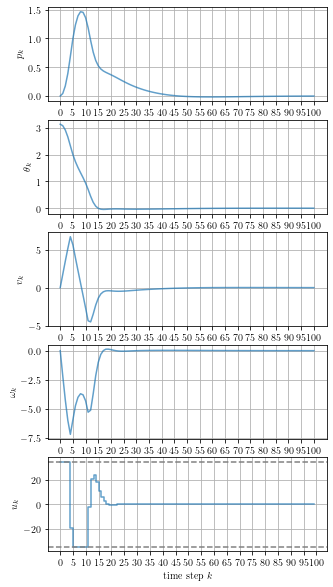

In [4]:
plot_trajectories_pendulum_on_cart(s_traj, a_traj, a_max, a_min)

### 6.3 Closed Loop Simulation with Noise

Introduce noise to your closed-loop simulation and compare the control performance.

In [5]:
N_steps = 100
N_horizon = 20

ocp_solver = OCPsolver(model, stage_cost, terminal_cost, N_horizon, a_max, -a_max)

s_traj = np.zeros((ns, N_steps+1))
a_traj = np.zeros((na, N_steps))

# generate noise trajectory
w_traj = 0.01*np.random.normal(size=(ns, N_steps))

s0 = np.array([0, np.pi, 0, 0])

# closed-loop simulation
s_traj[:, 0] = s0

for n in range(N_steps):
    s = s_traj[:, n]
    a = ocp_solver.solve(s)

    a_traj[:, n] = a
    s_traj[:, [n+1]] = model.simulate(s, a, w0=w_traj[:, [n]])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      384
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      170

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 151  1.5796347e+07 8.93e-01 1.77e+06  -1.0 3.14e+02    -  8.87e-05 2.76e-03f  1
 152  1.5795527e+07 8.93e-01 1.77e+06  -1.0 3.20e+02    -  3.80e-03 2.80e-05f  1
 153  1.5141079e+07 8.84e-01 1.73e+06  -1.0 3.05e+02    -  8.36e-02 2.28e-02f  1
 154  1.4978424e+07 8.79e-01 1.72e+06  -1.0 2.67e+02    -  2.35e-02 5.96e-03f  1
 155  1.3881569e+07 8.43e-01 1.65e+06  -1.0 2.89e+02    -  1.86e-02 4.14e-02f  1
 156  1.3789574e+07 8.40e-01 1.64e+06  -1.0 5.15e+02    -  9.71e-04 3.71e-03f  1
 157  1.3788305e+07 8.40e-01 1.64e+06  -1.0 3.81e+02    -  2.52e-04 5.15e-05f  1
 158  1.3776149e+07 8.39e-01 1.64e+06  -1.0 2.93e+02    -  3.58e-02 4.98e-04f  1
 159  1.2689903e+07 7.75e-01 1.57e+06  -1.0 2.97e+02    -  9.41e-04 4.56e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.2549163e+07 7.69e-01 1.56e+06  -1.0 3.50e+02    -  3.14e-02 6.45e-03f  1
 161  1.1716806e+07 6.91e-01 1.50e+06  -1.0 3.69e+02    -  1.44e-03 3.93e-02f  1
 162  1.1506622e+07 6.80e-01

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9237666e+05 1.56e+00 3.54e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.7409808e+05 1.22e+00 3.45e+01  -1.0 7.06e+01    -  9.10e-02 2.22e-01f  1
   2  2.2933943e+05 5.36e-01 1.14e+01  -1.0 4.31e+01    -  3.33e-02 1.00e+00f  1
   3  2.2206549e+05 1.78e-02 1.70e+00  -1.0 1.40e+01    -  5.22e-01 1.00e+00f  1
   4  2.1895721e+05 1.42e-02 2.53e+00  -1.0 1.39e+01    -  7.34e-01 1.00e+00f  1
 

   nlp_jac_g  |   2.87ms (261.09us)   2.87ms (261.32us)        11
       total  |  25.95ms ( 25.95ms)  24.08ms ( 24.08ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      384
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      170

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality c

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  25.00us (  3.57us)  25.54us (  3.65us)         7
       nlp_g  | 366.00us ( 52.29us) 375.68us ( 53.67us)         7
    nlp_grad  | 172.00us (172.00us) 172.05us (172.05us)         1
  nlp_grad_f  |  38.00us (  4.75us)  36.52us (  4.56us)         8
  nlp_hess_l  |   5.47ms (912.17us)   5.47ms (912.48us)         6
   nlp_jac_g  |   2.05ms (256.50us)   2.06ms (256.88us)         8
       total  |  17.12ms ( 17.12ms)  16.10ms ( 16.10ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      384
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      170

Total number of variables............................:      104
                     variables with only lower bounds:        0
        

   2  2.0442870e+02 9.03e-08 6.96e-04  -1.0 9.32e-02    -  1.00e+00 1.00e+00f  1
   3  2.0442838e+02 1.11e-11 2.68e-08  -2.5 1.05e-03    -  1.00e+00 1.00e+00h  1
   4  2.0442838e+02 5.79e-16 1.95e-12  -3.8 7.72e-06    -  1.00e+00 1.00e+00h  1
   5  2.0442838e+02 2.78e-17 7.70e-14  -5.7 3.98e-07    -  1.00e+00 1.00e+00h  1
   6  2.0442838e+02 5.55e-17 8.53e-14  -8.6 4.94e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   2.3406328483069501e+01    2.0442837944970577e+02
Dual infeasibility......:   8.5265128291212022e-14    7.4469654703649134e-13
Constraint violation....:   5.5511151231257827e-17    5.5511151231257827e-17
Complementarity.........:   2.5059038224962891e-09    2.1886297026903878e-08
Overall NLP error.......:   2.5059038224962891e-09    2.1886297026903878e-08


Number of objective function evaluations             = 7
Number of objective gradient evaluations          

                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3213416e+01 1.43e-02 2.57e-12  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0505464e+02 3.87e-06 5.52e-02  -1.0 9.95e-01    -  9.65e-01 1.00e+00h  1
   2  1.0504413e+02 2.89e-09 3.67e-05  -1.0 2.79e-02    -  1.00e+00 1.00e+00f  1
   3  1.0504412e+02 7.66e-14 8.59e-10  -2.5 1.44e-04    -  1.00e+00 1.00e+00h  1
   4  1.0504412e+02 2.78e-17 3.98e-13  -3.8 2.44e-06    -  1.00e+00 1.00e+00h  1
   5  1.0504412e+02 2.78e-17 1.85e-13  -5.7 1.34e-07    -  1.00e+

   1  6.3353838e+01 1.29e-05 7.80e-02  -1.0 8.19e-01    -  9.71e-01 1.00e+00f  1
   2  6.3347105e+01 2.25e-09 4.85e-05  -1.0 5.59e-02    -  1.00e+00 1.00e+00h  1
   3  6.3347106e+01 6.88e-14 1.72e-09  -2.5 3.31e-04    -  1.00e+00 1.00e+00h  1
   4  6.3347106e+01 4.16e-17 2.28e-13  -3.8 3.37e-06    -  1.00e+00 1.00e+00h  1
   5  6.3347106e+01 2.78e-17 5.86e-14  -5.7 1.80e-07    -  1.00e+00 1.00e+00h  1
   6  6.3347106e+01 2.78e-17 8.70e-14  -8.6 2.24e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   9.6594435115591626e+00    6.3347105953205329e+01
Dual infeasibility......:   8.7041485130612273e-14    5.7082234336740143e-13
Constraint violation....:   2.7755575615628914e-17    2.7755575615628914e-17
Complementarity.........:   2.5059036835705454e-09    1.6433839688767728e-08
Overall NLP error.......:   2.5059036835705454e-09    1.6433839688767728e-08


Number of objective functi

Total CPU secs in NLP function evaluations           =      0.008

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  28.00us (  4.00us)  26.74us (  3.82us)         7
       nlp_g  | 385.00us ( 55.00us) 384.10us ( 54.87us)         7
    nlp_grad  |   1.06ms (  1.06ms) 233.66us (233.66us)         1
  nlp_grad_f  |  40.00us (  5.00us)  39.73us (  4.97us)         8
  nlp_hess_l  |   5.56ms (926.17us)   5.56ms (926.75us)         6
   nlp_jac_g  |   2.06ms (257.62us)   2.08ms (260.01us)         8
       total  |  19.24ms ( 19.24ms)  18.16ms ( 18.16ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      384
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      170

Total number of variables..............

   5  3.3783864e+01 2.08e-17 4.97e-14  -5.7 2.95e-08    -  1.00e+00 1.00e+00h  1
   6  3.3783864e+01 1.39e-17 5.68e-14  -8.6 3.66e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   5.9815780056043026e+00    3.3783863933864993e+01
Dual infeasibility......:   5.6843418860808015e-14    3.2105078735577258e-13
Constraint violation....:   1.3877787807814457e-17    1.3877787807814457e-17
Complementarity.........:   2.5059035788264983e-09    1.4153306277898632e-08
Overall NLP error.......:   2.5059035788264983e-09    1.4153306277898632e-08


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 7
Number o

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  34.00us (  4.86us)  33.84us (  4.83us)         7
       nlp_g  | 514.00us ( 73.43us) 496.04us ( 70.86us)         7
    nlp_grad  | 186.00us (186.00us) 185.98us (185.98us)         1
  nlp_grad_f  |  47.00us (  5.88us)  44.16us (  5.52us)         8
  nlp_hess_l  |   6.28ms (  1.05ms)   6.29ms (  1.05ms)         6
   nlp_jac_g  |   2.23ms (279.25us)   2.24ms (279.82us)         8
       total  |  19.78ms ( 19.78ms)  18.97ms ( 18.97ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      384
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      170

Total number of variables............................:      104
                     variables with only lower bounds:        0
        

   4  2.1483510e+01 1.39e-17 1.42e-13  -5.7 8.43e-08    -  1.00e+00 1.00e+00h  1
   5  2.1483510e+01 1.39e-17 3.13e-13  -8.6 1.04e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.2208562149237322e+01    2.1483510359308450e+01
Dual infeasibility......:   3.1263880373444408e-13    5.5015315453591894e-13
Constraint violation....:   1.3877787807814457e-17    1.3877787807814457e-17
Complementarity.........:   2.5059036164590125e-09    4.4096598473710399e-09
Overall NLP error.......:   2.5059036164590125e-09    4.4096598473710399e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number o

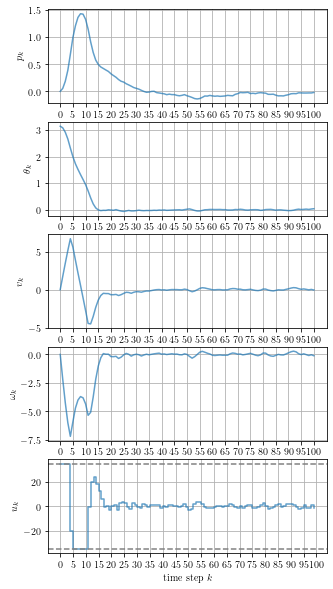

In [6]:
plot_trajectories_pendulum_on_cart(s_traj, a_traj, a_max, a_min)

### 6.4 Real-time iterations 
Since solving nonlinear optimization problems online can be rather computationally demanding, schemes are present in the literature that exploit approximate solutions. In the following, you will implement the so-called Real-Time Iteration (RTI) scheme, which relies on the solution of a single convex quadratic problem (QP) that locally approximates the above optimal control problem. In order to do so, consider the following formulation:
<img src="imgs/qp.png" alt="nlp" width="450"/>

where $A_i = \frac{\partial F}{\partial s}(\tilde{s}_i, \tilde{a}_i)$, $B_i = \frac{\partial F}{\partial a} (\tilde{s}_i, \tilde{a}_i) $ and where $(\tilde{s},\,\tilde{a})$ represent the linearization point at which the local approximation is computed. Notice that the nonlinear discretized dynamics have been replaced by a local time-varying model obtained by computing a Taylor series expansion of first order of the RK4 equations. Once a solution to the QP is obtained, the first control input is applied to the system and the linearization point is updated using the obtained state-input vector. 

Implement the RTI scheme in CasADi by replacing the NLP solver that you obtain with  `nlpsol('solver', 'ipopt', self.ocp)` by a QP solver, `qpsol('solver', 'qpoases', self.ocp)`.
The QP solver linearizes the NLP at the initial guess that you provide and solves the resulting QP, which has the form given above.

For the first OCP, initialize the $\theta$ component of your initial guess for the state trajectory with `np.linspace(np.pi, 0, N_horizon)`. Discuss why you need this initialization.

In [7]:
class  RTI_OCPsolver:

    def __init__(self, model, stage_cost, terminal_cost, N, a_max, a_min):

        self.N = N
        self.model = model

        ns = model.ns
        na = model.na

        # setup OCP

        # optimization variables
        s_traj = SX.sym('s_traj', ns*(N+1), 1)
        a_traj = SX.sym('a_traj', na*N, 1)

        # split trajectories to obtain x and u for each stage
        s_ns = vertsplit(s_traj, np.arange(0, ns*(N+1)+1, ns))
        a_ns = vertsplit(a_traj, np.arange(0, na*N+1, na))

        # initial state (will be a parameter of the optimization problem)
        s0_bar = SX.sym('s0_bar', ns, 1)

        cost = 0

        # initial constraint
        constraints = [s_ns[0] - s0_bar]

        for n in range(N):
            s0 = s_ns[n]
            a0 = a_ns[n]
            s1 = s_ns[n+1]
            
            f0 = model.f(s0, a0)

            # add stage cost to objective
            cost += stage_cost(s0, a0)

            # add continuity contraint
            constraints += [s1-f0] 
        
        # add terminal cost
        cost += terminal_cost(s1)

        # continuity constraints and bounds on u
        constraints = vertcat(*constraints, a_traj)

        # set upper and lower bounds 
        # zeros for continuity constraints, a_max/a_min fro control bounds
        self.ubg = vertcat(np.zeros((ns*(N+1))), a_max*np.ones((N*na)))
        self.lbg = vertcat(np.zeros((ns*(N+1))), a_min*np.ones((N*na)))

        self.ocp = {'f': cost, 'x': vertcat(s_traj, a_traj), 'g': constraints, 'p':s0_bar}
        self.solver = qpsol('solver', 'qpoases', self.ocp)

        # initialize current solution guess
        self.s_current = np.zeros((ns*(N+1), 1))
        self.a_current = np.zeros((na*N, 1))


    def solve(self, s0, s_traj_init=None, a_traj_init=None):

        if s_traj_init is not None:
            self.s_current = s_traj_init

        if a_traj_init is not None:
            self.a_current = a_traj_init

        # solve the NLP
        sol = self.solver(x0=vertcat(self.s_current, self.a_current), lbg=self.lbg, ubg=self.ubg, p=s0)
        
        w_opt = sol['x'].full()

        s_opt = w_opt[:(self.N+1)*self.model.ns]
        a_opt = w_opt[(self.N+1)*self.model.ns:]

        cost = sol['f'].full()

        self.s_current = s_opt
        self.a_current = a_opt

        a0_opt = a_opt[:self.model.na]
        return a0_opt


    def reset(self):
        self.s_current = np.zeros((self.model.ns*(self.N+1), 1))
        self.a_current = np.zeros((self.model.na*self.N, 1))


In [8]:
N_steps = 100
N_horizon = 20

ocp_solver = RTI_OCPsolver(model, stage_cost, terminal_cost, N_horizon, a_max, -a_max)

s_traj = np.zeros((ns, N_steps+1))
a_traj = np.zeros((na, N_steps))

s0 = np.array([0, np.pi, 0, 0])

# initial guess
s_traj_init = np.zeros((ns, N_horizon+1))
s_traj_init[1, :] = np.linspace(np.pi, 0, N_horizon+1)

s_traj_init = np.reshape(s_traj_init, ((N_horizon+1)*ns,), order='F')

# closed-loop simulation
s_traj[:, 0] = s0

for n in range(N_steps):
    s = s_traj[:, n]
    
    if n == 0:
        a = ocp_solver.solve(s, s_traj_init = s_traj_init)
    else:
        a = ocp_solver.solve(s)

    a_traj[:, n] = a
    s_traj[:, [n+1]] = model.simulate(s, a)




####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   6.004854e-12   |   REM BND   81   |   103   |     0   
       1   |   2.268122e-11   |   REM BND   77   |   102   |     0   
       2   |   2.156153e-14   |   REM BND   73   |   101   |     0   
       3   |   2.181116e-14   |   REM BND   69   |   100   |     0   
       4   |   2.206514e-14   |   REM BND   65   |    99   |     0   
       5   |   2.232359e-14   |   REM BND   61   |    98   |     0   
       6   |   2.258661e-14   |   REM BND   57   |    97   |     0   
       7   |   2.285430e-14   |   REM BND   53   |    96   |     0   
       8   |   2.312678e-14   |   REM BND   49   |    95   |     0   
       9   |   2.340417e-14   |   REM BND   45   |    94   |     0   
      10   |   2.368657e-14   |   REM BND   41   |    93   |     0   
      11   |  

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   5.932823e-02   |   REM CON   58   |     0   |    89   
       1   |   5.898052e-16   |   ADD CON   58   |     0   |    90   
       2   |   4.944110e-02   |   REM CON   33   |     0   |    89   
       3   |   0.000000e+00   |   ADD CON   33   |     0   |    90   
       4   |   1.048542e-05   |   REM CON   13   |     0   |    89   
       5   |   1.151542e-05   |   REM CON   21   |     0   |    88   
       6   |   1.686789e-07   |   REM CON   25   |     0   |    87   
       7   |   2.781788e-07   |   REM CON   17   |     0   |    86   
       8   |   3.048110e-06   |   REM CON   29   |     0   |    85   
       9   |   6.463157e-06   |   ADD CON   13   |     0   |    86   
      10   |   2.424122e-05   |   ADD CON   17   |     0   |    87   
      11   |   3.745211e-05   |   REM CON   15   |     0   |    86   
      12   |   1.9

      48   |   2.601478e-03   |   REM CON   70   |     0   |    81   
      49   |   2.500596e-03   |   REM CON   67   |     0   |    80   
      50   |   7.087546e-02   |   ADD CON    5   |     0   |    81   
      51   |   1.694240e-03   |   REM CON    9   |     0   |    80   
      52   |   3.071806e-03   |   ADD CON   70   |     0   |    81   
      53   |   1.050953e-03   |   REM CON   17   |     0   |    80   
      54   |   5.333470e-03   |   ADD CON   67   |     0   |    81   
      55   |   9.868870e-04   |   REM CON   59   |     0   |    80   
      56   |   4.549701e-03   |   REM CON   58   |     0   |    79   
      57   |   2.077314e-02   |   ADD CON   66   |     0   |    80   
      58   |   1.221739e-02   |   ADD CON   58   |     0   |    81   
      59   |   1.819956e-04   |   REM CON   60   |     0   |    80   
      60   |   1.504427e-03   |   REM CON   54   |     0   |    79   
      61   |   2.274545e-03   |   ADD CON   60   |     0   |    80   
      62   |   2.779

 ----------+------------------+------------------+---------+--------- 
       0   |   2.551588e-01   |   REM CON  103   |     0   |   103   
       1   |   5.457668e-02   |   ADD CON  103   |     0   |   104   
       2   |   1.906136e-01   |   REM CON  100   |     0   |   103   
       3   |   2.549507e-01   |   ADD CON  100   |     0   |   104   
       4   |   3.072356e-01   |   REM CON   97   |     0   |   103   
       5   |   4.838978e-01   |   REM CON  102   |     0   |   102   
       6   |   2.165980e-01   |   ADD CON   97   |     0   |   103   
       7   |   8.915823e-02   |   ADD CON  102   |     0   |   104   
       8   |   5.698718e-01   |   REM CON   98   |     0   |   103   
       9   |   3.483445e-01   |   ADD CON   98   |     0   |   104   
      10   |   6.855420e-02   |   REM CON   92   |     0   |   103   
      11   |   7.499918e-01   |   REM CON    0   |     0   |   102   
      12   |   0.000000e+00   |   ADD CON    0   |     0   |   103   
      13   |   2.51

      71   |   1.693642e-05   |   REM CON   30   |     0   |    78   
      72   |   5.834191e-05   |   REM CON   26   |     0   |    77   
      73   |   7.134075e-05   |   REM CON   51   |     0   |    76   
      74   |   3.414572e-04   |   ADD CON   30   |     0   |    77   
      75   |   1.331383e-04   |   REM CON   87   |     0   |    76   
      76   |   4.460968e-04   |   ADD CON   34   |     0   |    77   
      77   |   1.260180e-04   |   REM CON   22   |     0   |    76   
      78   |   8.575120e-04   |   ADD CON   81   |     0   |    77   
      79   |   2.764488e-04   |   REM CON   91   |     0   |    76   
      80   |   2.085054e-04   |   REM CON   79   |     0   |    75   
      81   |   1.731536e-04   |   REM CON   78   |     0   |    74   
      82   |   6.605145e-05   |   REM CON   47   |     0   |    73   
      83   |   9.500977e-04   |   REM CON   84   |     0   |    72   
      84   |   2.040719e-03   |   REM CON   30   |     0   |    71   
      85   |   1.950

      34   |   1.071484e-03   |   REM CON  103   |     0   |    77   
      35   |   1.103111e-04   |   REM CON   52   |     0   |    76   
      36   |   4.540714e-04   |   REM CON   48   |     0   |    75   
      37   |   4.216758e-04   |   REM CON   86   |     0   |    74   
      38   |   5.953514e-04   |   ADD CON   25   |     0   |    75   
      39   |   6.385345e-03   |   REM CON   44   |     0   |    74   
      40   |   1.249239e-03   |   REM CON   56   |     0   |    73   
      41   |   3.166642e-03   |   REM CON   31   |     0   |    72   
      42   |   1.936003e-04   |   REM CON   29   |     0   |    71   
      43   |   3.998949e-03   |   REM CON   88   |     0   |    70   
      44   |   6.476580e-05   |   REM CON   91   |     0   |    69   
      45   |   7.743588e-04   |   REM CON   90   |     0   |    68   
      46   |   2.716704e-04   |   ADD CON   44   |     0   |    69   
      47   |   1.062971e-03   |   REM CON   89   |     0   |    68   
      48   |   2.584

       5   |   1.800779e-01   |   ADD CON   83   |     0   |    90   
       6   |   1.258284e-01   |   ADD CON   78   |     0   |    91   
       7   |   1.372364e-02   |   REM CON   79   |     0   |    90   
       8   |   1.200124e-01   |   ADD CON   79   |     0   |    91   
       9   |   1.624896e-02   |   REM CON   74   |     0   |    90   
      10   |   7.245378e-02   |   ADD CON   90   |     0   |    91   
      11   |   6.243938e-02   |   ADD CON   74   |     0   |    92   
      12   |   3.076993e-02   |   REM CON   75   |     0   |    91   
      13   |   1.060688e-01   |   ADD CON   75   |     0   |    92   
      14   |   2.959895e-02   |   REM CON   95   |     0   |    91   
      15   |   2.266566e-02   |   REM CON   70   |     0   |    90   
      16   |   7.007522e-02   |   ADD CON   95   |     0   |    91   
      17   |   4.720402e-02   |   ADD CON   70   |     0   |    92   
      18   |   1.239024e-02   |   REM CON   95   |     0   |    91   
      19   |   5.590

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   1.849304e-01   |   REM CON   59   |     0   |    83   
       1   |   0.000000e+00   |   ADD CON   59   |     0   |    84   
       2   |   4.284772e-04   |   REM CON   58   |     0   |    83   
       3   |   5.685891e-01   |   ADD CON   58   |     0   |    84   
       4   |   3.436007e-01   |   REM CON   63   |     0   |    83   
       5   |   3.679107e-01   |   ADD CON   63   |     0   |    84   
       6   |   5.749497e-02   |   REM CON   62   |     0   |    83   
       7   |   3.124842e-01   |   ADD CON   62   |     0   |    84   
       8   |   9.634310e-01   |   REM CON   67   |     0   |    83   
       9   |   2.221767e-01   |   ADD CON   67   |     0   |    84   
      10   |   1.000000e+00   |    QP SOLVED     |     0   |    84   


####################   qpOASES  --  QP NO.  31   #####################

    Iter   |  

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   1.000000e+00   |    QP SOLVED     |     0   |    84   


####################   qpOASES  --  QP NO.  66   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   1.000000e+00   |    QP SOLVED     |     0   |    84   


####################   qpOASES  --  QP NO.  67   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   1.000000e+00   |    QP SOLVED     |     0   |    84   


####################   qpOASES  --  QP NO.  68   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 


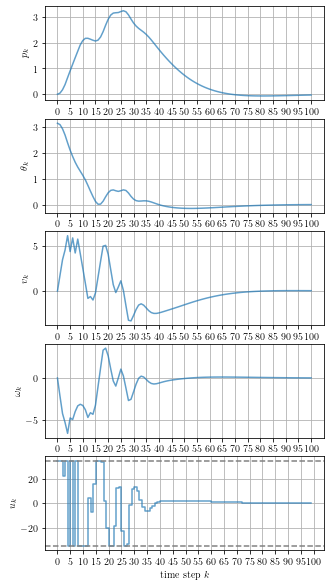

In [9]:
plot_trajectories_pendulum_on_cart(s_traj, a_traj, a_max, a_min)

### 6.4 Optional: acados

If you have `acados` installed, you can solve the same OCP with `acados`.

In [10]:
from acados_template import AcadosModel
from casadi import SX, vertcat, sin, cos, Function

model_name = 'pendulum_ode'

model_acados = AcadosModel()

model_acados.f_expl_expr = s_dot
model_acados.x = s_expr
model_acados.u = a_expr
model_acados.name = model_name

In [11]:
import scipy.linalg
from acados_template import AcadosOcp, AcadosOcpSolver

# create ocp object to formulate the OCP
ocp = AcadosOcp()

# set model
ocp.model = model_acados

N_horizon = 20
Tf = N_horizon*dt
nx = ns
nu = na
ny = nx + nu
ny_e = nx
N = 20

# set dimensions
ocp.dims.N = N_horizon

# set cost module
ocp.cost.cost_type = 'EXTERNAL'
ocp.cost.cost_type_e = 'EXTERNAL'

ocp.model.cost_expr_ext_cost = stage_cost_expr
ocp.model.cost_expr_ext_cost_e = terminal_cost_expr


# set constraints
s0 = np.array([0, np.pi, 0, 0])
ocp.constraints.constr_type = 'BGH'
ocp.constraints.lbu = np.array([a_min])
ocp.constraints.ubu = np.array([a_max])
ocp.constraints.x0 = s0
ocp.constraints.idxbu = np.array([0])

ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
ocp.solver_options.integrator_type = 'ERK'
ocp.solver_options.nlp_solver_type = 'SQP' # SQP_RTI

# set prediction horizon
ocp.solver_options.tf = Tf

acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')

s_traj = np.zeros((ns, N_steps+1))
a_traj = np.zeros((na, N_steps))

# generate noise trajectory
w_traj = 0.0*np.random.normal(size=(ns, N_steps))

# initial guess
s_traj_init = np.zeros((ns, N_horizon+1))
s_traj_init[1, :] = np.linspace(np.pi, 0, N_horizon+1)


for i in range(N_horizon+1):
    acados_ocp_solver.set(i, "x", s_traj_init[:, i])

# closed-loop simulation
s_traj[:, 0] = s0

for n in range(N_steps):

    s = s_traj[:, n]
    
    # solve ocp
    acados_ocp_solver.set(0, "lbx", s)
    acados_ocp_solver.set(0, "ubx", s)

    status = acados_ocp_solver.solve()

    if status != 0:
        raise Exception('acados acados_ocp_solver returned status {}. Exiting.'.format(status))

    a = acados_ocp_solver.get(0, "u")
    a_traj[:, n] = a
    s_traj[:, [n+1]] = model.simulate(s, a, w0=w_traj[:, [n]])
    

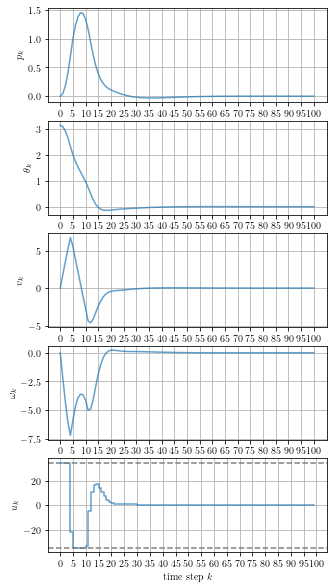

In [12]:
plot_trajectories_pendulum_on_cart(s_traj, a_traj, a_max, a_min)